In [302]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns # in case
import cv2
import os
import rarfile
import pickle 

from joblib import load as joblibLoad
from joblib import dump as joblibdump

from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [303]:
import os
from sklearn.model_selection import train_test_split
import shutil

source_directory = 'C:\\Users\\thedu\\OneDrive\\Documents\\machine_learning\\CNN_dataset\\extracted_folder\\'

train_dir = './train/'
test_dir = './test/'
val_dir = './validation/'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

class_directories = [os.path.join(source_directory, f) for f in os.listdir(source_directory)]

for class_dir in class_directories:
    class_name = os.path.basename(class_dir)

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    train_images, test_val_images = train_test_split(images, test_size=0.2, random_state=42)
    test_images, val_images = train_test_split(test_val_images, test_size=0.5, random_state=42)

    for img in train_images:
        shutil.copy(img, os.path.join(train_dir, class_name, os.path.basename(img)))

    for img in test_images:
        shutil.copy(img, os.path.join(test_dir, class_name, os.path.basename(img)))

    for img in val_images:
        shutil.copy(img, os.path.join(val_dir, class_name, os.path.basename(img)))

In [304]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = train_datagen.flow_from_directory(
    'C:\\Users\\thedu\\OneDrive\\Documents\\machine_learning\\CNN_dataset\\train', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)

val_dataset = train_datagen.flow_from_directory(
    'C:\\Users\\thedu\\OneDrive\\Documents\\machine_learning\\CNN_dataset\\validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)

test_dataset = train_datagen.flow_from_directory(
    'C:\\Users\\thedu\\OneDrive\\Documents\\machine_learning\\CNN_dataset\\test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    seed=42
)

Found 2596 images belonging to 8 classes.


Found 328 images belonging to 8 classes.
Found 324 images belonging to 8 classes.


In [305]:
test_dataset.image_shape

(224, 224, 3)

In [306]:
def create_model(activation, dimension):
    model = models.Sequential()
    model.add(layers.InputLayer(dimension))

    # New architecture with 3 layers
    model.add(layers.Conv2D(64, 3, activation=activation, padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2, padding='valid'))

    model.add(layers.Conv2D(128, 3, activation=activation, padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2, padding='valid'))

    model.add(layers.Conv2D(256, 3, activation=activation, padding='same'))
    model.add(layers.MaxPooling2D(pool_size=2, padding='valid'))

    # Flatten
    model.add(layers.Flatten())

    # FCN
    model.add(layers.Dense(256, activation=activation))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation=activation))
    model.add(layers.Dropout(0.3))

    # Output
    model.add(layers.Dense(8, activation='softmax'))

    model.summary()
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss=losses.CategoricalCrossentropy(from_logits=False),
        metrics=[
            metrics.CategoricalAccuracy(),
            metrics.Recall(),
            metrics.Precision(),
            metrics.AUC(),
            metrics.TruePositives(),
            metrics.TrueNegatives(),
            metrics.FalseNegatives(),
            metrics.FalsePositives()
        ]
    )

    return model

In [307]:
model = create_model('relu',train_dataset.image_shape)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_76 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 56, 56, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_77 (Conv2D)          (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 28, 28, 256)      

In [308]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
    epochs=30,
    validation_data=val_dataset,
    validation_steps=val_dataset.samples // val_dataset.batch_size
)

Epoch 1/30
81/81 [==============================] - 133s 2s/step - loss: 1.9844 - categorical_accuracy: 0.1923 - recall_27: 0.0000e+00 - precision_27: 0.0000e+00 - auc_8: 0.6374 - true_positives_8: 0.0000e+00 - true_negatives_8: 17948.0000 - false_negatives_8: 2564.0000 - false_positives_8: 0.0000e+00 - val_loss: 1.8157 - val_categorical_accuracy: 0.3625 - val_recall_27: 0.0000e+00 - val_precision_27: 0.0000e+00 - val_auc_8: 0.7596 - val_true_positives_8: 0.0000e+00 - val_true_negatives_8: 2240.0000 - val_false_negatives_8: 320.0000 - val_false_positives_8: 0.0000e+00
Epoch 2/30
81/81 [==============================] - 132s 2s/step - loss: 1.5670 - categorical_accuracy: 0.4044 - recall_27: 0.1264 - precision_27: 0.6694 - auc_8: 0.8144 - true_positives_8: 324.0000 - true_negatives_8: 17788.0000 - false_negatives_8: 2240.0000 - false_positives_8: 160.0000 - val_loss: 1.0994 - val_categorical_accuracy: 0.6438 - val_recall_27: 0.2500 - val_precision_27: 0.8081 - val_auc_8: 0.9310 - val_tru

In [309]:
# Save the training history to a file
history_file_path = 'C:\\Users\\thedu\\OneDrive\\Documents\\machine_learning\\CNN_dataset\\results\\history_DL_example.pkl'
with open(history_file_path, 'wb') as file:
    pickle.dump(history.history, file)

In [310]:
# Save the model in the native Keras format
model_file_path = 'C:\\Users\\thedu\\OneDrive\\Documents\\machine_learning\\CNN_dataset\\results\\DL_example'
model.save(model_file_path)

INFO:tensorflow:Assets written to: C:\Users\thedu\OneDrive\Documents\machine_learning\CNN_dataset\results\DL_example\assets


INFO:tensorflow:Assets written to: C:\Users\thedu\OneDrive\Documents\machine_learning\CNN_dataset\results\DL_example\assets


In [311]:
# Load the training history from the file
with open(history_file_path, 'rb') as f:
    history = pickle.load(f)

In [312]:
print(history)

{'loss': [1.9843568801879883, 1.5669569969177246, 1.1391417980194092, 0.8800636529922485, 0.7068935036659241, 0.6114010810852051, 0.46769943833351135, 0.3936317563056946, 0.33392953872680664, 0.2557011842727661, 0.26410651206970215, 0.2004413604736328, 0.17422938346862793, 0.15174853801727295, 0.12075603008270264, 0.13012953102588654, 0.10269776731729507, 0.08415132015943527, 0.09108815342187881, 0.07333685457706451, 0.0631098672747612, 0.06831566989421844, 0.04683161526918411, 0.04925703629851341, 0.04116634652018547, 0.028908222913742065, 0.03803253918886185, 0.03476822376251221, 0.07174454629421234, 0.0374896265566349], 'categorical_accuracy': [0.1922776848077774, 0.40444618463516235, 0.5767747163772583, 0.6825273036956787, 0.7515600919723511, 0.7823712825775146, 0.8221529126167297, 0.8615444898605347, 0.8802652359008789, 0.9130265116691589, 0.9075663089752197, 0.9270671010017395, 0.9414976835250854, 0.950078010559082, 0.9590483903884888, 0.9598283767700195, 0.9672386646270752, 0.97

In [313]:
from matplotlib import pyplot as plt

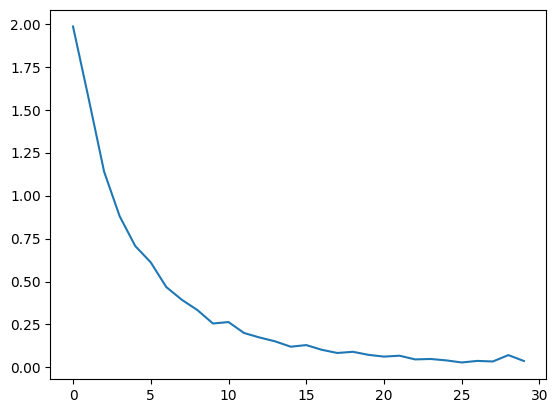

In [314]:
plt.plot(history['loss'])

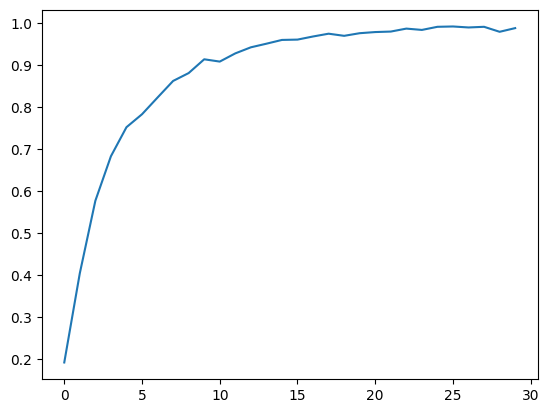

In [315]:
plt.plot(history['categorical_accuracy'])

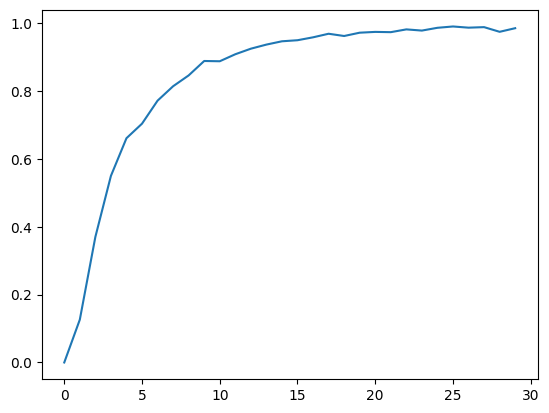

In [317]:
plt.plot(history['recall_27'])

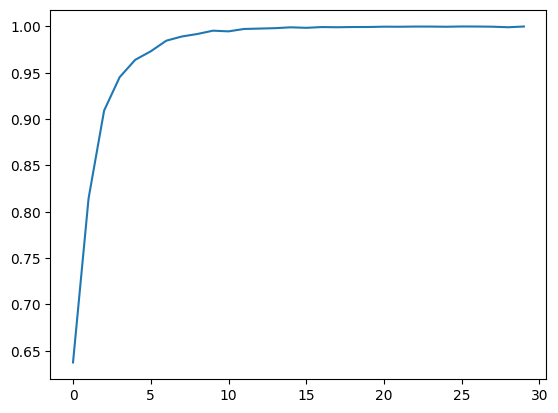

In [320]:
plt.plot(history['auc_8'])

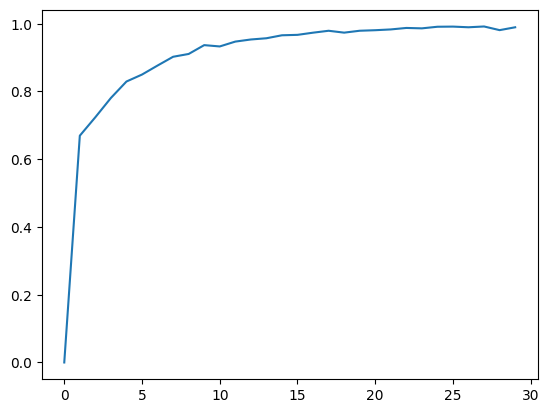

In [319]:
plt.plot(history['precision_27'])

In [321]:
def get_best_epoch(history):
    max_precision_epoch = history['precision_27'].index(max(history['precision_27'])) + 1
    max_recall_epoch = history['recall_27'].index(max(history['recall_27'])) + 1
    best_epoch = min(max_precision_epoch, max_recall_epoch)
    precision_at_best_epoch = history['precision_27'][best_epoch - 1]
    recall_at_best_epoch = history['recall_27'][best_epoch - 1]
    f1_score = 2 * (precision_at_best_epoch * recall_at_best_epoch) / (precision_at_best_epoch + recall_at_best_epoch)
    print("Best epoch with highest precision and recall:", best_epoch)
    print("Precision at best epoch:", precision_at_best_epoch)
    print("Recall at best epoch:", recall_at_best_epoch)
    print(f"F1 Score: {f1_score}")


get_best_epoch(history)

Best epoch with highest precision and recall: 26
Precision at best epoch: 0.991416335105896
Recall at best epoch: 0.9910296201705933
F1 Score: 0.9912229399200811
